# Imports

In [1]:
import glob
import json
import os
import pickle
import warnings
from ast import literal_eval

import awkward as ak

# import latexify
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal as signal
import uproot
from itables import init_notebook_mode
from matplotlib.colors import LinearSegmentedColormap, LogNorm, to_rgba
from matplotlib.ticker import AutoMinorLocator, MaxNLocator, ScalarFormatter
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy import stats
from scipy.optimize import curve_fit
from skimage.measure import LineModelND, ransac
from sklearn.cluster import DBSCAN, KMeans
from sklearn.linear_model import RANSACRegressor
from skspatial.objects import Cylinder, Line, Plane, Point, Triangle
from tqdm.auto import tqdm

init_notebook_mode(all_interactive=True)

# Parameters

README 

- `non_track_keys = 5` has to be updated if new keys are added to an event in metrics

In [2]:
metrics_file = "combined/metrics.pkl"

In [3]:
sipm_map_file = "sipm_sn_ch_to_xy.json"

# Load options
reload_files = False
rematch_events = False

# Save options
overwrite_metrics = True
save_figures = True

# Plotting options
individual_plots = np.arange(1, 50, 1)
show_figures = True

# Events to process
event_list = None

# Noisy Pixels
channel_disable_list = [7]

# Light variable to consider
light_variable = "integral"

# Units for plot labels
q_unit = "e"  # After applying charge_gain
xy_unit = "mm"
z_unit = "mm"
dh_unit = "?" if z_unit != xy_unit else xy_unit
time_unit = "ns"
light_unit = "p.e." if light_variable == "integral" else "p.e./time bin"

# Conversion factors
charge_gain = 245  # mV to e
detector_z = 300
detector_x = 128
detector_y = 160
quadrant_size = 32  # One SiPM + LArPix cell

# DBSCAN parameters for charge clustering
min_samples = 2
xy_epsilon = 8  # 8 ideal
z_epsilon = 8  # 8 ideal

# RANSAC parameters for line fitting
ransac_residual_threshold = 6  # 6 ideal for charge, 35 ideal for light
ransac_max_trials = 1000
ransac_min_samples = 2  # 2 ideal for charge, 3 ideal for light

# Force parameters for cylinder
force_dh = None
force_dr = None

# Filters for post processing
score_cutoff = -1.0
max_score = 1.0
min_track_length = 30
max_track_length = np.inf
max_tracks = 1

# Other
non_track_keys = 5

In [4]:
file_label = "_".join(metrics_file.split(".")[0].split("_")[1:])
if file_label == "metrics":
    file_label = "combined"

# Functions

## Parameter calculators

In [5]:
# SiPMs mapping
sipm_map = None


def sipm_to_xy(sn, ch):
    global sipm_map
    if sipm_map is None:
        with open(sipm_map_file, "r") as f:
            sipm_map = json.load(f)

    xy = sipm_map.get(str(sn), {}).get(str(ch), None)
    if xy is None:
        return None
    else:
        x = xy[0] + 64
        y = xy[1] - 16
        return (x, y)


# Check if SiPMs on anode area
def get_sipm_mask(sn, ch):
    xy = sipm_to_xy(sn, ch)
    # return True
    if xy is None:
        return False
    else:
        return (
            xy[0] > -detector_x / 2
            and xy[0] < detector_x / 2
            and xy[1] < detector_y / 2
            and xy[1] > -detector_y / 2
        )

In [6]:
# Cylinder parameters for dQ/dx
def get_dh(unit_vector):
    if force_dh is not None:
        return force_dh

    dl_vector = np.array([xy_epsilon, xy_epsilon, z_epsilon])
    min_dh = np.linalg.norm(dl_vector) / 4
    max_dh = 2 * np.linalg.norm(dl_vector)
    dl_projection = abs(np.dot(unit_vector, dl_vector))
    dh = min(max(dl_projection, min_dh), max_dh)

    return dh


def get_dr(rmse):
    if force_dr is not None:
        return force_dr

    dl_vector = np.array([xy_epsilon, xy_epsilon, z_epsilon])
    min_dr = np.linalg.norm(dl_vector) / 4
    dr = max(rmse, min_dr)

    return dr

## Data handling

### Charge

In [7]:
# Create a list of fake data
def generate_dead_area(z_range):
    # Dead area on chips 44, 54, detector_x/2
    fake_x1, fake_y1, fake_z1 = np.meshgrid(
        np.linspace(36, 60, 6),
        np.concatenate(
            [
                np.linspace(-76, -52, 6),
                np.linspace(-44, -20, 6),
                np.linspace(-12, 12, 6),
            ]
        ),
        z_range,
    )

    # Dead area on chip 33
    fake_x2, fake_y2, fake_z2 = np.meshgrid(
        np.linspace(4, 28, 6), np.linspace(20, 44, 6), z_range
    )

    # Dead area on chip 42
    fake_x3, fake_y3, fake_z3 = np.meshgrid(
        np.linspace(-28, -4, 6), np.linspace(-12, 12, 6), z_range
    )
    mask = fake_x3 + (fake_y3 + 16) <= 0
    fake_x3, fake_y3, fake_z3 = fake_x3[mask], fake_y3[mask], fake_z3[mask]

    fake_x4, fake_y4, fake_z4 = np.meshgrid([-14], [2], z_range)

    # Dead area on SiPMs
    fake_x5 = []
    fake_y5 = []
    fake_z5 = []
    for k in range(4):
        for l in range(5):
            if (k == 3 and l < 3) or (k == 2 and l == 3) or (k == 1 and l == 2):
                continue

            temp_x, temp_y, temp_z = np.meshgrid(
                np.array([-50, -46]) + 32 * k,
                np.array([-66, -62]) + 32 * l,
                z_range,
            )

            temp_x2, temp_y2, temp_z2 = np.meshgrid(
                np.array([-58]) + 32 * k,
                np.array([-58]) + 32 * l,
                np.arange(10),
            )

            fake_x5.extend(np.append(temp_x, temp_x2))
            fake_y5.extend(np.append(temp_y, temp_y2))
            fake_z5.extend(np.append(temp_z, temp_z2))

    fake_x5 = np.array(fake_x5)
    fake_y5 = np.array(fake_y5)
    fake_z5 = np.array(fake_z5)

    # Concatenate all the fake data
    fake_x = np.concatenate(
        [
            fake_x1.flatten(),
            fake_x2.flatten(),
            fake_x3.flatten(),
            fake_x4.flatten(),
            fake_x5.flatten(),
        ]
    )
    fake_y = np.concatenate(
        [
            fake_y1.flatten(),
            fake_y2.flatten(),
            fake_y3.flatten(),
            fake_y4.flatten(),
            fake_y5.flatten(),
        ]
    )
    fake_z = np.concatenate(
        [
            fake_z1.flatten(),
            fake_z2.flatten(),
            fake_z3.flatten(),
            fake_z4.flatten(),
            fake_z5.flatten(),
        ]
    )

    fake_data = np.c_[fake_x, fake_y, fake_z]

    return fake_data

In [8]:
# Apply DBSCAN clustering
def cluster_hits(hitArray):
    # First stage clustering
    z_intervals = []
    first_stage = DBSCAN(eps=xy_epsilon, min_samples=min_samples).fit(hitArray[:, 0:2])
    for label in first_stage.labels_:
        if label > -1:
            mask = first_stage.labels_ == label
            z = hitArray[mask, 2]
            z_intervals.append((min(z), max(z)))

    # Sort the intervals based on their start points
    sorted_intervals = sorted(z_intervals, key=lambda interval: interval[0])

    # Initialize a list to store the intervals representing the empty space
    empty_space_ranges = []

    # Iterate through the sorted intervals to find the gaps
    for i in range(len(sorted_intervals) - 1):
        current_interval = sorted_intervals[i]
        next_interval = sorted_intervals[i + 1]

        # Calculate the gap between the current interval and the next interval
        gap_start = current_interval[1]
        gap_end = next_interval[0]

        # Check if there is a gap (empty space) between intervals
        if gap_end > gap_start and gap_end < gap_start + 40:
            empty_space_ranges.append(np.arange(gap_start, gap_end, z_epsilon))

    if not empty_space_ranges:
        empty_space_ranges.append(
            np.arange(
                np.mean(hitArray[:, 2]) - np.std(hitArray[:, 2]),
                np.mean(hitArray[:, 2]) + np.std(hitArray[:, 2]),
                z_epsilon,
            )
        )

    z_range = np.concatenate(empty_space_ranges)

    # Create a list of holes
    fake_data = generate_dead_area(z_range)
    fake_data_count = len(fake_data)

    # Second stage clustering
    # Combine fake to true data
    second_stage_data = np.concatenate([hitArray, fake_data])
    second_stage = DBSCAN(eps=xy_epsilon, min_samples=1).fit(second_stage_data[:, 0:2])

    # Third stage clustering
    # Create a new array with z and labels
    third_stage_z = np.c_[second_stage.labels_ * 1e3, second_stage_data[:, 2]]
    flag = second_stage.labels_ > -1
    third_stage_data = third_stage_z[flag].copy()
    third_stage = DBSCAN(
        eps=z_epsilon, min_samples=min_samples, metric="chebyshev"
    ).fit(third_stage_data)

    # Remove fake data
    # Shift labels by 1 so that negative values are reserved for outliers
    labels = third_stage.labels_[:-fake_data_count] + 1

    return labels


# Apply Ransac Fit
def ransacFit(
    hitArray,
    weightArray=None,
    min_samples=None,
    residual_threshold=None,
):
    if weightArray is not None:
        estimator = RANSACRegressor(
            min_samples=min_samples,
            max_trials=ransac_max_trials,
            residual_threshold=residual_threshold,
        )
        last_column = len(hitArray[0]) - 1
        inliers = estimator.fit(
            hitArray[:, 0:last_column],
            hitArray[:, last_column],
            sample_weight=weightArray,
        ).inlier_mask_

        # Check it enouth inliers
        if sum(inliers) > ransac_min_samples:
            score = estimator.score(
                hitArray[:, 0:last_column], hitArray[:, last_column]
            )
        else:
            score = np.nan
    else:
        model_robust, inliers = ransac(
            hitArray,
            LineModelND,
            min_samples=min_samples,
            residual_threshold=residual_threshold,
            max_trials=ransac_max_trials,
        )

        # Check it enouth inliers
        if sum(inliers) > ransac_min_samples:
            score = model_robust.residuals(hitArray)
        else:
            score = np.nan

    outliers = inliers == False
    return inliers, outliers, score


# Apply best line fit
def lineFit(hitArray):
    line = Line.best_fit(hitArray)
    max_point = Point(np.max(hitArray, axis=0))
    min_point = Point(np.min(hitArray, axis=0))
    centre_point = (max_point + min_point) / 2
    line.point = line.project_point(centre_point)
    residuals = np.array([line.distance_point(point) for point in hitArray])

    # Calculate chi-squared
    mse = np.sum(residuals**2) / len(residuals)

    return line, mse


# Calculate dQ/dx from a line fit
def dqdx(hitArray, q, line_fit, dh, dr, h, ax=None):
    # Cylinder steps for dQ/dx
    steps = np.arange(-3 * dh, h + 3 * dh, dh)

    # Mask of points that have been accounted for
    counted = np.zeros(len(q), dtype=bool)

    # Array of dQ values for each step
    dq_i = np.zeros(len(steps), dtype=float)

    for step_idx, step in enumerate(steps):
        cylinder_fit = Cylinder(
            line_fit.to_point(h / 2 - step),
            -line_fit.direction.unit() * dh,
            dr,
        )
        if ax is not None:
            cylinder_fit.plot_3d(ax)

        for point_idx, point in enumerate(hitArray):
            if not counted[point_idx] and cylinder_fit.is_point_within(point):
                counted[point_idx] = True
                dq_i[step_idx] += q[point_idx]

    return dq_i


# Fit clusters with Ransac method
def fit_hit_clusters(
    hitArray, q, labels, ax2d=None, ax3d=None, plot_cyl=False, refit_outliers=True
):
    metrics = {}
    # Fit clusters
    idx = 0
    condition = lambda: idx < len(np.unique(labels))
    while condition():
        label = np.unique(labels)[idx]
        mask = labels == label
        if label > 0 and mask.sum() > min_samples:
            xyz_c = hitArray[mask]
            q_c = np.array(q)[mask]

            norm = np.linalg.norm(np.max(xyz_c, axis=0) - np.min(xyz_c, axis=0))

            # Fit the model
            inliers, outliers, score = ransacFit(
                xyz_c,
                weightArray=q_c - min(q_c) + 1,
                min_samples=ransac_min_samples,
                residual_threshold=ransac_residual_threshold,
            )

            # Refit outliers
            level_1 = np.where(mask)[0]
            level_2 = np.where(outliers)[0]
            level_3 = level_1[level_2]

            if refit_outliers and sum(outliers) > min_samples:
                outlier_labels = cluster_hits(xyz_c[outliers])
                last_label = max(labels) + 1
                # Assign positive labels to clustered outliers and negative labels to unlclustered outliers
                for i, j in enumerate(level_3):
                    labels[j] = (outlier_labels[i] + last_label) * (
                        1 if outlier_labels[i] > 0 else -1
                    )
            else:
                # Assign negative labels to outliers
                for j in level_3:
                    labels[j] = -labels[j]

            if sum(inliers) > min_samples:
                line_fit, mse = lineFit(xyz_c[inliers])

                if ax2d is not None:
                    # 2D plot
                    line_fit.plot_2d(
                        ax2d,
                        t_1=-norm / 2,
                        t_2=norm / 2,
                        c="red",
                        label=f"Track {label}",
                        zorder=10,
                    )
                if ax3d is not None:
                    # 3D plot
                    line_fit.plot_3d(
                        ax3d,
                        t_1=-norm / 2,
                        t_2=norm / 2,
                        c="red",
                        label=f"Track {label}",
                    )

                # Calculate dQ/dx
                dh = get_dh(line_fit.direction)
                dr = get_dr(np.sqrt(mse))

                dq_i = dqdx(
                    xyz_c[inliers],
                    q_c[inliers],
                    line_fit,
                    dh=dh,
                    dr=dr,
                    h=norm,
                    ax=ax3d if ax3d is not None and plot_cyl else None,
                )

                q_eff = dq_i.sum() / q_c[inliers].sum()
                if dq_i.sum() != 0:
                    dq = dq_i
                else:
                    dq = 0

                metrics[label] = {
                    "Fit_line": line_fit,
                    "Fit_norm": norm,
                    "Fit_mse": mse,
                    "RANSAC_score": score,
                    "q_eff": q_eff,
                    "dQ": dq,
                    "dx": dh,
                }

        idx = np.unique(labels).tolist().index(label) + 1

    metrics["Fit_labels"] = labels

    return metrics

### Light

In [9]:
def voxelize_hits(
    charge_df,
    sipm_df,
    light_variable,
    fit_light=True,
    charge_lines=[],
):
    sipm_voxels_metrics = {}
    xyzl_df = pd.DataFrame()
    for row, sipm in sipm_df.dropna(subset=light_variable).iterrows():
        voxel_mask = (abs(charge_df["x"] - sipm["x"]) <= quadrant_size / 2) & (
            abs(charge_df["y"] - sipm["y"]) <= quadrant_size / 2
        )
        voxel_charge = charge_df["q"][voxel_mask]
        voxel_z = charge_df["z"][voxel_mask]
        xyzl = sipm[["x", "y", light_variable]].copy()

        if len(voxel_charge) > 0:
            sipm_idx = (sipm["sn"], sipm["ch"])
            sipm_voxels_metrics[sipm_idx] = {}
            voxel_mean_z = np.average(voxel_z, weights=voxel_charge)
            voxel_total_charge = voxel_charge.sum()
            sipm_voxels_metrics[sipm_idx]["charge_q"] = voxel_total_charge
            sipm_voxels_metrics[sipm_idx]["charge_z"] = voxel_mean_z
            sipm_voxels_metrics[sipm_idx][light_variable] = sipm[light_variable]
            xyzl["z"] = voxel_mean_z
        else:
            xyzl["z"] = np.average(charge_df["z"], weights=charge_df["q"])

            if charge_lines:
                point = Point([sipm["x"], sipm["y"], 0])
                plane = Plane(point=point, normal=[0, 0, 1])
                line_distances = [
                    (
                        line.distance_point(point)
                        if not plane.normal.is_parallel(line.direction)
                        else np.inf
                    )
                    for line in charge_lines
                ]
                if line_distances and min(line_distances) < np.inf:
                    charge_line = charge_lines[np.argmin(line_distances)]
                    projection = plane.project_line(charge_line)
                    projected_point = projection.project_point(point)
                    v_line = Line(point=projected_point, direction=[0, 0, 1])
                    intersection = charge_line.intersect_line(
                        v_line, check_coplanar=False
                    )
                    if all(abs(projected_point - point)[:2] <= quadrant_size / 2):
                        xyzl["z"] = intersection[2]

        xyzl_df = pd.concat([xyzl_df, xyzl], axis=1)

    if not xyzl_df.empty and fit_light:
        xyzl_df = xyzl_df.T
        xyzl_df = xyzl_df.sort_values(by=light_variable, ascending=False)
        xyzl_df = xyzl_df[xyzl_df[light_variable] > 0]
        if len(xyzl_df) > 3:
            # dbscan = DBSCAN(eps=quadrant_size, metric="chebyshev", min_samples=2)
            # labels = dbscan.fit(xyzl_df[["x", "y"]].values).labels_
            # unique, counts = np.unique(labels[labels>-1],return_counts=True)
            # if len(counts)>0 and max(counts)>3:
            #     label = unique[counts.argmax()]

            #     xyz = xyzl_df[labels==label].head(5)
            xyzl = xyzl_df.head(5).astype(float)
            inliers, outliers, score = ransacFit(
                xyzl[["x", "y", "z"]].values,
                weightArray=xyzl[light_variable].values,
                min_samples=3,
                residual_threshold=10,
            )
            if inliers.sum() > 2:
                light_fit, mse = lineFit(xyzl[["x", "y", "z"]][inliers].values)
                sipm_voxels_metrics["Fit_line"] = light_fit
                sipm_voxels_metrics["RANSAC_score"] = score
                sipm_voxels_metrics["Fit_mse"] = mse
                sipm_voxels_metrics["Fit_threshold"] = xyzl[light_variable][
                    inliers
                ].min()

    return sipm_voxels_metrics

In [10]:
def light_geometry(track_line, track_norm, sipm_df, light_variable="integral"):
    metrics = {}
    point1 = track_line.to_point(-track_norm / 2)
    point2 = track_line.to_point(track_norm / 2)
    centre = track_line.point

    iterate_df = sipm_df.dropna(subset=light_variable).copy()
    for row, sipm in iterate_df.iterrows():
        sipm_idx = (sipm["sn"], sipm["ch"])
        point3 = Point([sipm["x"], sipm["y"], 0])
        triangle = Triangle(point1, point2, point3)
        angle = triangle.angle("C")
        distance = point3.distance_point(centre)
        metrics[sipm_idx] = {}
        metrics[sipm_idx]["distance"] = distance
        metrics[sipm_idx]["angle"] = angle
        metrics[sipm_idx][light_variable] = sipm[light_variable]

    return metrics

### Helpers

In [11]:
def max_std(array, ax=None, array_max=None, min_count_ratio=0.9, max_std_ratio=0.5):
    max_std = array.std()
    max_count = len(array)
    if array_max is None:
        array_max = np.percentile(array, min(min_count_ratio * 100 + 1, 100))

    std = []
    count = []
    x_range = range(int(min(array)), (int(array_max) + 1), 1)
    for i in x_range:
        cut = array[array < i]
        std.append(cut.std())
        count.append(len(cut))

    std = np.array(std)
    count = np.array(count)
    condition = ((count / max_count).round(3) >= min_count_ratio) & (
        (std / max_std).round(3) <= max_std_ratio
    )
    vline = x_range[
        (
            np.where(condition)[0][-1]
            if np.any(condition)
            else (count / max_count > min_count_ratio).argmax()
        )
    ]

    print(
        "Max STD ratio",
        max_std_ratio,
        "limited to",
        min_count_ratio * 100,
        "% of events:",
        vline,
        "\n",
    )
    if ax is not None:
        ax.plot(std / max_std, label="STD ratio")
        ax.plot(count / max_count, label="Event count ratio")
        ax.axvline(vline, ls="--", c="r", label=f"{min_count_ratio*100}% of events")
        ax.legend()
        ax.tick_params(
            axis="both", direction="inout", which="major", top=True, right=True
        )
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.grid(alpha=0.25)

    return vline

In [12]:
def cluster_hot_bins(min_n_ratio, n, x_edges, y_edges, scale=(1, 1), eps=8):
    n[np.isnan(n)] = 0
    min_n = min_n_ratio * n.max()
    filtered_n2 = n[n >= min_n]
    bin_centers_x = 0.5 * (x_edges[1:] + x_edges[:-1])
    bin_centers_y = 0.5 * (y_edges[1:] + y_edges[:-1])
    filtered_centers_x, filtered_centers_y = np.array(
        np.meshgrid(bin_centers_x, bin_centers_y)
    )
    filtered_centers_x = filtered_centers_x[n.T > min_n]
    filtered_centers_y = filtered_centers_y[n.T > min_n]
    dbscan = DBSCAN(
        eps=eps, min_samples=int(np.sqrt(len(filtered_centers_y))), metric="chebyshev"
    ).fit(np.c_[filtered_centers_x / scale[0], filtered_centers_y / scale[1]])
    return filtered_centers_x, filtered_centers_y, dbscan.labels_

In [13]:
def filter_metrics(
    metrics,
    min_score=0.5,
    max_score=np.inf,
    min_track_length=160,
    max_track_length=np.inf,
    max_tracks=1,
):
    print(f"min_score = {min_score}")
    print(f"max_score = {max_score}")
    print(f"min_track_length = {min_track_length}")
    print(f"max_track_length = {max_track_length}")
    print(f"max_tracks = {max_tracks}")

    filtered_metrics = {}

    for event_idx, metric in metrics.items():
        if len(metric) <= max_tracks + non_track_keys:
            candidate_metric = {
                track_idx: values
                for track_idx, values in metric.items()
                if isinstance(track_idx, str)
                or (
                    track_idx > 0
                    and values["RANSAC_score"] >= min_score
                    and values["RANSAC_score"] <= max_score
                    and values["Fit_norm"] >= min_track_length
                    and values["Fit_norm"] <= max_track_length
                )
            }
            if (
                len(candidate_metric) <= max_tracks + non_track_keys
                and len(candidate_metric) > non_track_keys
            ):
                filtered_metrics[event_idx] = candidate_metric

    print(f"{len(filtered_metrics)} metrics remaining")
    return filtered_metrics

In [14]:
def combine_metrics():
    combined_metrics = {}

    for file in tqdm(glob.glob("**/*.pkl"), leave=True):
        folder = file.split("/")[0]
        tqdm.write(folder)
        with open(file, "rb") as f:
            metric = pickle.load(f)
            for key, value in tqdm(metric.items(), leave=False):
                combined_metrics[f"{folder}_{key}"] = value

    if not os.path.exists("combined"):
        os.makedirs("combined")

    with open("combined/metrics.pkl", "wb") as o:
        pickle.dump(combined_metrics, o)

    print("Done")

    return combined_metrics

## Plotting

In [15]:
class OOMFormatter(ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        ScalarFormatter.__init__(self, useOffset=offset, useMathText=mathText)

    def _set_order_of_magnitude(self):
        self.orderOfMagnitude = self.oom

    def _set_format(self, vmin=None, vmax=None):
        self.format = self.fformat
        if self._useMathText:
            self.format = r"$\mathdefault{%s}$" % self.format


def set_common_ax_options(ax):
    ax.tick_params(axis="both", direction="inout", which="major", top=True, right=True)
    ax.set_axisbelow(True)
    ax.grid(alpha=0.25)
    if not ax.get_xscale() == "log":
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        if ax.get_xlim()[1] > 1.1:
            ax.xaxis.set_major_locator(MaxNLocator(integer=(ax.get_xlim()[1] > 2)))
            if ax.get_xlim()[1] > 1e3:
                ax.xaxis.set_major_formatter(OOMFormatter(3, "%1.1f"))

    if not ax.get_yscale() == "log":
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        if ax.get_ylim()[1] > 1.1:
            ax.yaxis.set_major_locator(MaxNLocator(integer=(ax.get_ylim()[1] > 2)))
            if ax.get_ylim()[1] > 1e3:
                ax.yaxis.set_major_formatter(OOMFormatter(3, "%1.1f"))

### Event display

In [16]:
# Function to create a square based on center coordinates and side size
def create_square(center, side_size):
    x = [
        center[0] - side_size / 2,
        center[0] + side_size / 2,
        center[0] + side_size / 2,
        center[0] - side_size / 2,
        center[0] - side_size / 2,
    ]
    y = [
        center[1] - side_size / 2,
        center[1] - side_size / 2,
        center[1] + side_size / 2,
        center[1] + side_size / 2,
        center[1] - side_size / 2,
    ]
    z = [0, 0, 0, 0, 0]  # All z-coordinates are set to 0 to align with the xy-plane

    vertices = [(x[i], y[i], z[i]) for i in range(5)]
    square = [[vertices[0], vertices[1], vertices[2], vertices[3]]]
    return square

In [17]:
def create_ed_axes(event_idx, charge, light):
    fig = plt.figure(figsize=(14, 6))
    ax3d = fig.add_subplot(121, projection="3d")
    ax2d = fig.add_subplot(122)
    fig.suptitle(
        f"Event {event_idx} - Charge = {charge} {q_unit} - Light = {light} {light_unit}"
    )
    grid_color = plt.rcParams["grid.color"]

    # Draw dead areas
    for i in range(4):
        j = 0
        if i == 3:
            j = 1
        ax2d.plot(
            np.arange(32, 64 + 1, 1) - 32 * j,
            np.arange(-80, -48 + 1, 1) + 32 * i,
            c=grid_color,
            lw=1,
        )
        ax2d.plot(
            np.arange(64, 32 - 1, -1) - 32 * j,
            np.arange(-80, -48 + 1, 1) + 32 * i,
            c=grid_color,
            lw=1,
        )

    # ax2d.plot(np.linspace(-31,0),np.linspace(8,-16), c=grid_color,lw = 1)
    ax2d.plot(np.linspace(-32, 0), np.linspace(16, -16), c=grid_color, lw=1, zorder=-1)
    ax2d.plot(np.linspace(-32, -16), np.linspace(-16, 0), c=grid_color, lw=1, zorder=-1)

    # Adjust axes
    for ax in [ax3d, ax2d]:
        ax.set_aspect("equal", adjustable="box")
        ax.set_xlim([-detector_x / 2, detector_x / 2])
        ax.set_ylim([-detector_y / 2, detector_y / 2])
        ax.set_xlabel(f"x [{xy_unit}]")
        ax.set_ylabel(f"y [{xy_unit}]")
        ax.set_xticks(np.linspace(-detector_x / 2, detector_x / 2, 5))
        ax.set_yticks(np.linspace(-detector_y / 2, detector_y / 2, 6))
        ax.grid()

    ax2d.xaxis.set_minor_locator(AutoMinorLocator(8))
    ax2d.yaxis.set_minor_locator(AutoMinorLocator(8))
    ax2d.tick_params(axis="both", which="both", right=True, top=True)

    # Adjust z-axis
    ax3d.set_zlabel(f"z [{z_unit}]")
    # ax3d.zaxis.set_major_locator(MaxNLocator(integer=True))

    return fig, (ax2d, ax3d)


def event_display(
    event_idx,
    charge_df,
    light_df,
    plot_cyl=False,
):
    if len(charge_df) < 2:
        return None

    # Plot the hits
    fig, axes = create_ed_axes(
        event_idx, round(sum(charge_df["q"])), round(sum(light_df[light_variable]))
    )
    ax2d = axes[0]
    ax3d = axes[1]

    # Group by x and y coordinates and sum the z values
    unique_points, indices = np.unique(
        charge_df[["x", "y"]], axis=0, return_inverse=True
    )
    q_sum = np.bincount(indices, weights=charge_df["q"])

    # Plot the hits
    plot3d = ax3d.scatter(
        charge_df["x"],
        charge_df["y"],
        charge_df["z"],
        c=charge_df["q"],
        marker="s",
        s=30,
        vmin=q_sum.min(),
        vmax=q_sum.max(),
    )
    plot2d = ax2d.scatter(
        unique_points[:, 0],
        unique_points[:, 1],
        c=q_sum,
        marker="s",
        s=40,
        vmin=q_sum.min(),
        vmax=q_sum.max(),
    )
    cbar = plt.colorbar(plot2d)
    cbar.set_label(f"charge [{q_unit}]")

    # Cluster the hits
    labels = cluster_hits(charge_df[["x", "y", "z"]].to_numpy())

    # Fit clusters
    metrics = fit_hit_clusters(
        charge_df[["x", "y", "z"]].to_numpy(),
        charge_df["q"].to_numpy(),
        labels,
        ax2d,
        ax3d,
        plot_cyl,
    )

    # Draw missing SiPMs
    grid_color = plt.rcParams["grid.color"]

    # Draw SiPMs
    sipm_plot = ax2d.scatter(
        light_df["x"],
        light_df["y"],
        c=light_df[light_variable],
        marker="s",
        s=200,
        linewidths=1.5,
        edgecolors=grid_color,
        zorder=6,
    )

    # Draw SiPMs
    side_size = 6
    vertices_x = np.array([1, 1, -1, -1, 1]) * side_size / 2
    vertices_y = np.array([1, -1, -1, 1, 1]) * side_size / 2
    light_xy = light_df[["x", "y"]].apply(tuple, axis=1)
    for missing_index in range(20):
        col = -48 + (missing_index % 4) * 32
        row = 64 - (missing_index // 4) * 32
        square = create_square((col, row), side_size)
        if not light_xy.isin([(col, row)]).any():
            ax2d.fill(col + vertices_x, vertices_y + row, c=grid_color, zorder=5)
            ax3d.add_collection3d(Poly3DCollection(square, color=grid_color))
        else:
            ax3d.add_collection3d(
                Poly3DCollection(
                    square,
                    facecolors=sipm_plot.to_rgba(
                        light_df[light_variable][light_xy == (col, row)]
                    ),
                    linewidths=0.5,
                    edgecolors=grid_color,
                )
            )

    sipm_cbar = plt.colorbar(sipm_plot)
    sipm_cbar.set_label(rf"Light {light_variable} [{light_unit}]")

    ax3d.set_zlim([0, ax3d.get_zlim()[1]])
    # ax3d.view_init(160, 110, -85)
    ax3d.view_init(30, 20, 100)
    # ax3d.view_init(0, 0, 0)
    # ax3d.view_init(0, 0, 90)
    fig.tight_layout()

    if save_figures:
        os.makedirs(f"{file_label}/{event_idx}", exist_ok=True)
        fig.savefig(
            f"{file_label}/{event_idx}/event_{event_idx}.png",
            dpi=300,
            bbox_inches="tight",
        )

    return metrics

In [18]:
def plot_fake_data(z_range):
    fake_data = generate_dead_area(z_range)
    fake_x, fake_y, fake_z = fake_data[:, 0], fake_data[:, 1], fake_data[:, 2]

    fig = plt.figure()

    ax = fig.add_subplot(111)
    ax.set_aspect("equal", adjustable="box")
    ax.scatter(fake_x, fake_y, marker="s", s=20)
    ax.set_xlim([-detector_x / 2, detector_x / 2])
    ax.set_ylim([-detector_y / 2, detector_y / 2])
    ax.set_xlabel(f"x [{xy_unit}]")
    ax.set_ylabel(f"y [{xy_unit}]")
    ax.set_xticks(np.linspace(-detector_x / 2, detector_x / 2, 5))
    ax.set_yticks(np.linspace(-detector_y / 2, detector_y / 2, 6))
    ax.xaxis.set_minor_locator(AutoMinorLocator(8))
    ax.yaxis.set_minor_locator(AutoMinorLocator(8))
    ax.grid()
    ax.tick_params(axis="both", which="both", top=True, right=True)
    fig.tight_layout()
    fig.savefig("fake_data_map.png", dpi=300, bbox_inches="tight")

### Tracks

In [19]:
# Plot dQ versus X
def plot_dQ(dQ_array, event_idx, track_idx, dh, interpolate=False):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax_twinx = ax.twinx()

    fig.suptitle(
        rf"Event {event_idx} - Track {track_idx} - $dx = {round(dh,2)}$ {dh_unit}"
    )

    mean_dQ = np.mean(dQ_array[dQ_array > 0])
    non_zero_indices = np.where(dQ_array > 0)[0]

    # Check if there are non-zero values in dQ_array
    if non_zero_indices.size > 0:
        # Find the first non-zero index and add 2 indices before it
        first_index = max(non_zero_indices[0] - 2, 0)

        # Find the last non-zero index and add 2 indices after it
        last_index = min(non_zero_indices[-1] + 2, len(dQ_array))

        new_dQ_array = dQ_array.copy()[first_index:last_index]

        if interpolate:
            new_dQ_array[1:-1] = np.where(
                new_dQ_array[1:-1] == 0,
                mean_dQ,
                new_dQ_array[1:-1],
            )

        dQ_array = new_dQ_array

    ax.axhline(
        mean_dQ / dh,
        ls="--",
        c="red",
        label=rf"Mean = ${round(mean_dQ/dh,2)}$ {q_unit} {dh_unit}$^{{-1}}$",
        lw=1,
    )
    x_range = np.arange(0, len(dQ_array) * dh, dh)[: len(dQ_array)]

    ax.step(x_range, dQ_array / dh, where="mid")
    ax.set_xlabel(rf"$x$ [{dh_unit}]")
    ax.set_ylabel(rf"$dQ/dx$ [{q_unit} {dh_unit}$^{{-1}}$]")

    ax_twinx.step(x_range, np.cumsum(dQ_array), color="C1", where="mid")
    ax_twinx.set_ylabel(f"Q [{q_unit}]")

    for axes in [ax, ax_twinx]:
        set_common_ax_options(axes)

    h1, l1 = ax.get_legend_handles_labels()
    ax_twinx.legend(h1, l1, loc="lower center")

    ax.legend(loc="lower center")

    fig.tight_layout()
    if save_figures:
        os.makedirs(f"{file_label}/{event_idx}", exist_ok=True)
        fig.savefig(
            f"{file_label}/{event_idx}/dQ_E{event_idx}_T{track_idx}_{round(dh,2)}.png",
            dpi=300,
            bbox_inches="tight",
        )

In [20]:
def plot_track_stats(
    metrics,
    limit_xrange=True,
    min_score=0.5,
    empty_ratio_lims=(0, 1),
    min_entries=2,
    lognorm=True,
    profile=False,
    bins=[40, 40],
):
    track_mean_dQdx = []
    track_std_dQdx = []
    track_length = []
    track_score = []
    track_z = []
    dQdx_list = []

    empty_count = 0
    short_count = 0
    for entry in metrics.values():
        for track, values in entry.items():
            if isinstance(track, str) or track <= 0:
                continue

            dQ = values["dQ"]
            dx = values["dx"]
            non_zero_mask = np.where(dQ > 0)[0]

            if len(dQ[non_zero_mask]) < min_entries:
                short_count += 1
                continue

            empty_ratio = sum(dQ[non_zero_mask[0] : non_zero_mask[-1] + 1] == 0) / (
                non_zero_mask[-1] - non_zero_mask[0] + 1
            )

            if empty_ratio > empty_ratio_lims[1] or empty_ratio < empty_ratio_lims[0]:
                empty_count += 1
                continue

            dQdx = dQ[non_zero_mask[0] : non_zero_mask[-1] + 1] / dx
            x_range = np.arange(0, len(dQdx) * dx, dx)[: len(dQdx)]
            dQdx_list.append(pd.Series(dQdx, index=x_range))

            non_zero_mask = non_zero_mask[non_zero_mask[0] : non_zero_mask[-1] + 1]
            track_mean_dQdx.append(np.mean(dQdx[dQdx > 0]))
            track_std_dQdx.append(np.std(dQdx[dQdx > 0]))
            track_length.append(values["Fit_norm"])
            track_score.append(values["RANSAC_score"])
            track_z.append(values["Fit_line"].point[2])

    print(f"Tracks with dead area outside {empty_ratio_lims} interval: {empty_count}")
    print(f"Tracks with less than {min_entries} entries: {short_count}")

    track_mean_dQdx = pd.Series(track_mean_dQdx)
    track_std_dQdx = pd.Series(track_std_dQdx)
    track_length = pd.Series(track_length)
    track_score = pd.Series(track_score)
    track_z = pd.Series(track_z)
    mask = (
        track_mean_dQdx.notna()
        * track_length.notna()
        * track_score.notna()
        * track_z.notna()
    )

    print(f"Remaining tracks: {sum(mask)}")

    track_mean_dQdx = track_mean_dQdx[mask]
    track_std_dQdx = track_std_dQdx[mask]
    track_length = track_length[mask]
    track_score = track_score[mask]
    track_z = track_z[mask]
    track_cv_dQdx = track_std_dQdx / track_mean_dQdx
    dQdx_list = [series for i, series in enumerate(dQdx_list) if mask[i]]

    score_mask = (track_score >= min_score).to_numpy()
    score_bool = (1 - score_mask).sum() > 0

    print(f"Tracks with score < {min_score}: {sum(mask)-sum(score_mask)}")

    print(f"Remaining_tracks: {sum(score_mask)}")

    # 1D histograms
    fig1 = plt.figure(figsize=(14, 6))

    ax11 = fig1.add_subplot(121)
    ax12 = fig1.add_subplot(122)

    n_all11, bins_all11, patches_all11 = ax11.hist(
        track_mean_dQdx, bins=bins[0], label="All tracks"
    )

    n_all12, bins_all12, patches_all12 = ax12.hist(
        track_length, bins=bins[0], label="All tracks"
    )

    if score_bool:
        n11, edges11, patches11 = ax11.hist(
            track_mean_dQdx[score_mask],
            bins=bins_all11,
            label=rf"Score $\geq {min_score}$",
        )
        ax12.hist(
            track_length[score_mask],
            bins=bins_all12,
            label=rf"Score $\geq {min_score}$",
        )

    ax11.set_xlabel(rf"Mean $dQ/dx$ [{q_unit} {dh_unit}$^{{-1}}$]")
    ax11.set_title(f"{len(track_mean_dQdx)} tracks")
    ax12.set_title(f"{len(track_length)} tracks")

    # 2D histograms
    def hist2d(x, y, ax, bins, lognorm, fit="Log", profile=False):
        if profile:
            hist, x_edges, y_edges = np.histogram2d(x, y, bins=bins)

            y_means = [
                np.mean(y[(x >= x_edges[i]) & (x < x_edges[i + 1])])
                for i in range(len(x_edges) - 1)
            ]
            y_stds = [
                np.std(y[(x >= x_edges[i]) & (x < x_edges[i + 1])])
                for i in range(len(x_edges) - 1)
            ]
            x_values = (x_edges[1:] + x_edges[:-1]) / 2
            bin_widths = [
                (x_edges[i + 1] - x_edges[i]) / 2 for i in range(len(x_edges) - 1)
            ]
            ax.errorbar(x_values, y_means, yerr=y_stds, xerr=bin_widths, fmt="o")

        else:
            hist2d = ax.hist2d(
                x,
                y,
                bins=bins,
                cmin=1,
                norm=LogNorm() if lognorm else None,
            )
        if fit == "Log":
            x_fit = np.log(x)
        elif fit == "Linear":
            x_fit = x
        else:
            return

        try:
            fit_p = np.polyfit(x_fit, y, 1)
        except:
            if fit == "Log":
                x_fit = x  # Try linear fit as a fallback
                fit = "Linear"
            elif fit == "Linear":
                x_fit = np.log(x)  # Try log fit as a fallback
                fit = "Log"
            try:
                fit_p = np.polyfit(x_fit, y, 1)
            except:
                return

        p = np.poly1d(fit_p)
        x_plot = np.arange(min(x), max(x), 1)

        if fit == "Log":
            y_plot = p(np.log(x_plot))
        else:
            y_plot = p(x_plot)

        ax.plot(x_plot, y_plot, c="salmon", ls="-", label=f"{fit} fit")

    fig2 = plt.figure(figsize=(14, 6))
    ax21 = fig2.add_subplot(121)
    ax22 = fig2.add_subplot(122)

    fig2.suptitle(f"{len(track_mean_dQdx)} tracks")
    ax21.set_ylabel(rf"Mean $dQ/dx$ [{q_unit} {dh_unit}$^{{-1}}$]")
    ax21.set_title("Mean dQ/dx vs. Track length")
    ax22.set_ylabel(rf"$dQ/dx$ CV")
    ax22.set_title("dQ/dx CV vs. Track length")

    hist2d21 = hist2d(
        track_length, track_mean_dQdx, ax21, bins, lognorm, fit="Log", profile=profile
    )

    hist2d22 = hist2d(
        track_length, track_cv_dQdx, ax22, bins, lognorm, fit="Linear", profile=profile
    )

    fig4 = plt.figure(figsize=(7, 6))
    ax4 = fig4.add_subplot(111)
    ax4.set_ylabel(f"Fit score")
    ax4.set_title("Fit score vs. Track length")

    hist2d4 = hist2d(
        track_length,
        track_score,
        ax4,
        [bins[0], 40],
        lognorm,
        fit="Log",
        profile=profile,
    )

    cut_dQdx_series = pd.concat(
        [series for i, series in enumerate(dQdx_list) if score_mask[i]]
    )
    cut_dQdx_series = cut_dQdx_series[cut_dQdx_series > 0].dropna().sort_index()
    dQdx_series = pd.concat(dQdx_list)
    dQdx_series = dQdx_series[dQdx_series > 0].dropna().sort_index()

    fig5 = plt.figure(figsize=(7 + 7 * score_bool, 6))
    ax51 = fig5.add_subplot(111 + 10 * score_bool)
    ax51.set_ylabel(rf"$dQ/dx$ [{q_unit} {dh_unit}$^{{-1}}$]")
    ax51.set_xlabel(rf"Residual range [{dh_unit}]")
    ax51.set_title(rf"{len(track_mean_dQdx)} tracks")

    hist2d(
        dQdx_series.index,
        dQdx_series,
        ax51,
        bins,
        lognorm,
        fit="Linear",
        profile=profile,
    )

    fig6 = plt.figure(figsize=(7 + 7 * score_bool, 6))
    ax61 = fig6.add_subplot(111 + 10 * score_bool)
    ax61.set_ylabel(rf"Mean $dQ/dx$ [{q_unit} {dh_unit}$^{{-1}}$]")
    ax61.set_xlabel(rf"Anode distance [{z_unit}]")
    ax61.set_title(rf"{len(track_z)} tracks")

    hist2d(track_z, track_mean_dQdx, ax61, bins, lognorm, fit="Linear", profile=profile)

    axes = [ax11, ax12, ax21, ax22, ax4, ax51, ax61]
    figs = [fig1, fig2, fig4, fig5, fig6]

    if score_bool:
        # 2D histograms after RANSAC score cut
        fig3 = plt.figure(figsize=(14, 6))
        ax31 = fig3.add_subplot(121)
        ax32 = fig3.add_subplot(122)
        ax31.set_ylabel(rf"Mean $dQ/dx$ [{q_unit} {dh_unit}$^{{-1}}$]")
        ax31.set_title(rf"Mean dQ/dx vs. Track length")
        ax32.set_ylabel(rf"$dQ/dx$ CV")
        ax32.set_title(rf"dQ/dx CV vs. Track length")
        fig3.suptitle(
            rf"Fit score $\geq {min_score}$ ({round(sum(score_mask)/len(score_mask)*100)}% of tracks)"
        )

        figs.append(fig3)
        axes.extend([ax31, ax32])

        hist2d31 = hist2d(
            track_length[score_mask],
            track_mean_dQdx[score_mask],
            ax31,
            bins,
            lognorm,
            fit="Log",
            profile=profile,
        )

        hist2d32 = hist2d(
            track_length[score_mask],
            track_cv_dQdx[score_mask],
            ax32,
            bins,
            lognorm,
            fit="Linear",
            profile=profile,
        )

        ax52 = fig5.add_subplot(122)
        axes.append(ax52)
        ax52.set_ylabel(rf"$dQ/dx$ [{q_unit} {dh_unit}$^{{-1}}$]")
        ax52.set_xlabel(rf"Residual range [{dh_unit}]")
        ax52.set_title(
            rf"Fit score $\geq {min_score}$ ({round(sum(score_mask)/len(score_mask)*100)}% of tracks)"
        )
        fig5.suptitle("dQ/dx vs. Residual range")

        hist2d(
            cut_dQdx_series.index,
            cut_dQdx_series,
            ax52,
            bins,
            lognorm,
            fit="Linear",
            profile=profile,
        )

        ax62 = fig6.add_subplot(122)
        axes.append(ax62)
        ax62.set_ylabel(rf"Mean $dQ/dx$ [{q_unit} {dh_unit}$^{{-1}}$]")
        ax62.set_xlabel(rf"Mean anode distance [{z_unit}]")
        ax62.set_title(
            rf"Fit score $\geq {min_score}$ ({round(sum(score_mask)/len(score_mask)*100)}% of tracks)"
        )
        fig6.suptitle("Mean dQ/dx vs. Mean anode distance")

        hist2d(
            track_z[score_mask],
            track_mean_dQdx[score_mask],
            ax62,
            bins,
            lognorm,
            fit="Linear",
            profile=profile,
        )

    max_track_legth = np.sqrt(detector_x**2 + detector_y**2 + detector_z**2)
    max_track_legth_xy = np.sqrt(detector_x**2 + detector_y**2)
    print("Max possible track length", round(max_track_legth, 2), "mm")
    print("Max possible track lengt on xy plane", round(max_track_legth_xy, 2), "mm")
    print("Max possible vertical track length", detector_y, "mm")

    for ax in axes:
        set_common_ax_options(ax)
        if ax == ax11 or ax == ax12:
            ax.set_ylabel("Counts")
        if ax != ax11:
            if not (
                ax == ax51 or ax == ax61 or (score_bool and (ax == ax52 or ax == ax62))
            ):
                ax.set_xlabel(f"Track length [{dh_unit}]")
            if max(track_length) > detector_y:
                ax.axvline(detector_y, c="g", ls="--", label="Max vertical length")
            if max(track_length) > max_track_legth_xy:
                ax.axvline(
                    max_track_legth_xy, c="orange", ls="--", label=r"Max length in $xy$"
                )
            if max(track_length) > max_track_legth:
                ax.axvline(max_track_legth, c="r", ls="--", label="Max length")

            if ax != ax12:
                if limit_xrange:
                    xlim = ax.get_xlim()
                    ax.set_xlim(xlim[0], min(max_track_legth + 10, xlim[1]))
                cbar = plt.colorbar(ax.collections[0])
                cbar.set_label("Counts" + (" [log]" if lognorm else ""))
        if not (not score_bool and ax == ax11):
            ax.legend(loc="lower right" if ax == ax4 else "upper right")

    for fig in figs:
        fig.tight_layout()

    if save_figures:
        entries = len(track_mean_dQdx)
        fig1.savefig(
            f"{file_label}/track_stats_1D_hist_{file_label}_{entries}.png",
            dpi=300,
            bbox_inches="tight",
        )
        fig2.savefig(
            f"{file_label}/track_stats_2D_hist_{file_label}_{entries}{'_profile' if profile else ''}.png",
            dpi=300,
            bbox_inches="tight",
        )
        fig4.savefig(
            f"{file_label}/track_stats_score_{file_label}_{entries}{'_profile' if profile else ''}.png",
            dpi=300,
            bbox_inches="tight",
        )
        fig5.savefig(
            f"{file_label}/track_stats_dQdx_{file_label}_{entries}{'_profile' if profile else ''}.png",
            dpi=300,
            bbox_inches="tight",
        )
        fig6.savefig(
            f"{file_label}/track_stats_dQdx_z_{file_label}_{entries}{'_profile' if profile else ''}.png",
            dpi=300,
            bbox_inches="tight",
        )
        if score_bool:
            fig3.savefig(
                f"{file_label}/track_stats_2D_hist_cut_{file_label}_{entries}{'_profile' if profile else ''}.png",
                dpi=300,
                bbox_inches="tight",
            )

### Tracks and light

In [21]:
def plot_light_geo_stats(
    metrics,
    limit_xrange=False,
    light_max=None,
    min_count_ratio=0.99,
    max_std_ratio=0.2,
    single_track=True,
    lognorm=True,
):
    sipm_distance = []
    sipm_angle = []
    sipm_light = []

    for metric in metrics.values():
        if single_track and len(metric.keys()) > 1 + non_track_keys:
            continue
        for track_idx, values in metric.items():
            if not isinstance(track_idx, str) and track_idx > 0:
                sipms = values["SiPM"]
                for light in sipms.values():
                    sipm_distance.append(light["distance"])
                    sipm_angle.append(light["angle"])
                    sipm_light.append(light[light_variable])

    sipm_distance = np.array(sipm_distance)
    sipm_angle = np.array(sipm_angle)
    sipm_light = np.array(sipm_light)

    max_distance = np.sqrt(detector_x**2 + detector_y**2 + detector_z**2)
    print("Max possible distance to track", round(max_distance, 2), "mm")
    print("Drift distance", detector_z, "mm")

    sipm_distance = sipm_distance[~np.isnan(sipm_light) & (sipm_light > 0)]
    sipm_angle = sipm_angle[~np.isnan(sipm_light) & (sipm_light > 0)]
    sipm_light = sipm_light[~np.isnan(sipm_light) & (sipm_light > 0)]

    fig1 = plt.figure(figsize=(7, 6))
    ax1 = fig1.add_subplot(111)

    vline = max_std(
        sipm_light,
        ax1,
        array_max=light_max,
        max_std_ratio=max_std_ratio,
        min_count_ratio=min_count_ratio,
    )
    bins = vline

    ax1.set_xlabel("Max light integral")
    ax1.set_ylabel("Normalized value")

    fig1.suptitle("Light integral distribution")

    sipm_distance = sipm_distance[(sipm_light <= vline)]
    sipm_angle = sipm_angle[(sipm_light <= vline)]
    sipm_light = sipm_light[(sipm_light <= vline)]
    sipm_angle = np.degrees(sipm_angle)

    fig2, ax2 = plt.subplots(1, 1, figsize=(7, 6))
    axes = np.array(ax2)

    n2, x_edges2, y_edges2, image2 = ax2.hist2d(
        sipm_distance,
        sipm_angle,
        weights=abs(sipm_light),
        bins=bins,
        cmin=1,
        norm=LogNorm() if lognorm else None,
    )

    def triangle_calc(height, base):
        # Calculate the angle θ
        return np.degrees(2 * np.arctan((base / 2) / height))

    def inverse_triangle_calc(angle, height):
        # Calculate the base
        return 2 * height * np.tan(np.radians(angle / 2))

    filtered_centers_x2, filtered_centers_y2, cluster_labels = cluster_hot_bins(
        0.35, n2, x_edges2, y_edges2, scale=(3, 1), eps=8
    )

    # Create a LinearSegmentedColormap from the gradient
    salmon_cmap = LinearSegmentedColormap.from_list(
        "salmon_cmap",
        [
            to_rgba("darkred"),
            to_rgba("salmon"),
        ],
        N=np.unique(cluster_labels).size - 1,
    )

    x2 = np.arange(min(sipm_distance), max(sipm_distance), 1)
    for cluster_label in np.unique(cluster_labels):
        if cluster_label == -1:
            continue
        fit2 = parameters, cov = curve_fit(
            triangle_calc,
            filtered_centers_x2[cluster_labels == cluster_label],
            filtered_centers_y2[cluster_labels == cluster_label],
            p0=[
                inverse_triangle_calc(sipm_angle.mean(), sipm_distance.mean()),
            ],
        )
        print(f"Fit mean track length: {parameters[0]}")

        ax2.plot(
            x2,
            triangle_calc(x2, *parameters),
            ls="-",
            c=salmon_cmap(cluster_label),
            label=rf"Fit: {parameters[0]:.0f}{dh_unit} track length",
        )
    ax2.set_ylabel(f"SiPM opening angle to track centre [deg]")
    cbar2 = plt.colorbar(image2)
    cbar2.set_label(rf"Light {light_variable} [{light_unit} - log]")

    fig2.suptitle(f"SiPM level light distribution - {len(sipm_light)} entries")

    fig3, axes3 = plt.subplots(1, 2, figsize=(14, 6))
    axes = np.append(axes, axes3)

    hist30 = axes3[0].hist2d(
        sipm_distance,
        sipm_light,
        bins=bins,
        cmin=1,
        norm=LogNorm() if lognorm else None,
    )
    axes3[0].set_ylabel(f"Light_{light_variable} [{light_unit}]")
    cbar30 = plt.colorbar(hist30[3])
    cbar30.set_label(rf"Counts [Log]")

    hist31 = axes3[1].hist2d(
        sipm_angle, sipm_light, bins=bins, cmin=1, norm=LogNorm() if lognorm else None
    )
    axes3[1].set_xlabel(f"SiPM opening angle to track [deg]")
    axes3[1].set_ylabel(f"Light {light_variable} [{light_unit}]")
    cbar31 = plt.colorbar(hist31[3])
    cbar31.set_label(rf"Counts [Log]")

    fig3.suptitle(f"SiPM level light distribution - {len(sipm_light)} entries")

    for ax in axes:
        set_common_ax_options(ax)
        if ax == ax2 or ax == axes3[0]:
            if limit_xrange:
                xlim = ax.get_xlim()
                ax.set_xlim(xlim[0], min(max_distance + 10, xlim[1]))
            if max(sipm_distance) > detector_z:
                ax.axvline(detector_z, c="orange", ls="--", label="Drift distance")
            if max(sipm_distance) > max_distance:
                ax.axvline(max_distance, c="r", ls="--", label="Max distance")

            ax.set_xlabel(f"Distance from track centre [{dh_unit}]")

            ax.legend()

    for fig in [fig1, fig2, fig3]:
        fig.tight_layout()

    if save_figures:
        entries = len(sipm_light)
        fig1.savefig(
            f"{file_label}/light_geo_optimization_{file_label}_{entries}.png",
            dpi=300,
            bbox_inches="tight",
        )
        fig2.savefig(
            f"{file_label}/light_geo_2D_hist_{file_label}_{entries}.png",
            dpi=300,
            bbox_inches="tight",
        )
        fig3.savefig(
            f"{file_label}/light_geo_1D_hist_{file_label}_{entries}.png",
            dpi=300,
            bbox_inches="tight",
        )

In [22]:
def plot_light_fit_stats(metrics):
    cosine_df = pd.DataFrame(columns=["cosine", "threshold", "Light", "Charge"])
    for event, metric in metrics.items():
        if "Fit_line" not in metric["SiPM"]:
            continue
        light_track = metric["SiPM"]["Fit_line"]
        if len(metric.keys()) == non_track_keys + 1:
            for idx, track in metric.items():
                if isinstance(idx, str):
                    continue
                charge_track = track["Fit_line"]
                cross = charge_track.direction.cross(light_track.direction)
                cosine = abs(
                    charge_track.direction.cosine_similarity(light_track.direction)
                )
                cosine_df.loc[event] = [
                    cosine,
                    metric["SiPM"]["Fit_threshold"],
                    charge_track.direction,
                    light_track.direction,
                ]
    entries = len(cosine_df)
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    for i in range(0, int(cosine_df["threshold"].max()), 10):
        data = cosine_df[cosine_df["threshold"] > i]
        if len(data) > 0.005 * len(cosine_df):
            data.hist(
                "cosine",
                ax=ax,
                bins=np.linspace(0, 1, 11),
                label=f"Threshold: {i} {light_unit} - {len(cosine_df[cosine_df['threshold']>i])} entries",
            )
    ax.set(
        title="Cosine similarity between charge and light tracks",
        xlabel="Cosine similarity",
        ylabel="Counts",
    )
    set_common_ax_options(ax)
    ax.legend()
    fig.tight_layout()
    if save_figures:
        fig.savefig(
            f"{file_label}/light_fit_{file_label}_{entries}.png",
            dpi=300,
            bbox_inches="tight",
        )

### Light

In [23]:
def light_vs_charge(
    metrics,
    light_max=None,
    min_count_ratio=0.99,
    max_std_ratio=0.5,
    clusters=None,
    bin_density=1,
    log=(True, False),
    p0=True,
):
    if isinstance(log, bool):
        log = [log, log]

    light_array = []
    charge_array = []
    for event, metric in metrics.items():
        light_array.append(metric["Total_light"])
        charge_array.append(metric["Total_charge"])

    light_array = np.array(light_array)
    charge_array = np.array(charge_array)

    mask = (charge_array > 0) & (light_array > 0)
    charge_array = charge_array[mask]
    light_array = light_array[mask]

    fig1 = plt.figure(figsize=(8, 6))
    ax1 = fig1.add_subplot(111)
    ax1.set_xlabel("Max light integral")
    ax1.set_ylabel("Normalized value")
    fig1.suptitle("Light integral distribution")
    vline = max_std(
        light_array,
        ax1,
        array_max=light_max,
        min_count_ratio=min_count_ratio,
        max_std_ratio=max_std_ratio,
    )
    bins = int(vline / 20)

    charge_array = charge_array[(light_array <= vline)]
    light_array = light_array[(light_array <= vline)]

    def hist2d(x, y, ax, bins, log):
        if log:
            log_bins_x = np.exp(np.linspace(np.log(min(x) - 1), np.log(max(x)), bins))
            log_bins_y = np.exp(np.linspace(np.log(min(y)), np.log(max(y)), bins))
            bins = [log_bins_x, log_bins_y]
            ax.set_xscale("log")
            ax.set_yscale("log")

        n, x_edges, y_edges, image = ax.hist2d(x, y, bins=bins, cmin=1)

        # fit peak with curve_fit
        # @latexify.function(use_math_symbols=True)
        def fit_function(xy, amplitude, xo, yo, sigma_x, sigma_y):
            x, y = xy
            gauss = (
                amplitude
                * np.exp(-0.5 * ((x - xo) / sigma_x) ** 2)
                / (sigma_x * np.sqrt(2 * np.pi))
                * np.exp(-0.5 * ((y - yo) / sigma_y) ** 2)
                / (sigma_y * np.sqrt(2 * np.pi))
            )
            return gauss

        try:
            bin_peaks = n.ravel(order="F")
            bin_peaks[np.isnan(bin_peaks)] = 0
            x_bin_centers = 0.5 * (x_edges[1:] + x_edges[:-1])
            y_bin_centers = 0.5 * (y_edges[1:] + y_edges[:-1])
            x_bin_centers, y_bin_centers = np.array(
                np.meshgrid(x_bin_centers, y_bin_centers)
            )
            x_bin_centers = x_bin_centers.ravel()
            y_bin_centers = y_bin_centers.ravel()

            parameters, cov_matrix = curve_fit(
                fit_function,
                (
                    x_bin_centers / max(x_bin_centers),
                    y_bin_centers / max(y_bin_centers),
                ),
                bin_peaks,
                bounds=(0, np.inf),
            )
            plot_mesh = np.array(
                np.meshgrid(
                    np.linspace(min(x) / max(x), 1, len(x_bin_centers) * 5),
                    np.linspace(min(y) / max(y), 1, len(y_bin_centers) * 5),
                )
            )

            z_plot = fit_function(plot_mesh, *parameters)

            # print(latexify.get_latex(fit_function))
            print("Parameters:")
            print(
                "\n".join(
                    [
                        f"{name}: {value}"
                        for name, value in zip(
                            [
                                "amplitude",
                                "mu_x",
                                "mu_y",
                                "sigma_x",
                                "sigma_y",
                                "theta",
                            ],
                            parameters,
                        )
                    ]
                ),
                "\n",
            )
            contour = ax.contour(
                plot_mesh[0] * max(x),
                plot_mesh[1] * max(y),
                z_plot,
                norm="log",
                cmap="autumn",
                linewidths=1,
                levels=[
                    fit_function(
                        (
                            parameters[1] - 3 * parameters[3],
                            parameters[2] - 3 * parameters[4],
                        ),
                        *parameters,
                    ),
                    fit_function(
                        (
                            parameters[1] - 2 * parameters[3],
                            parameters[2] - 2 * parameters[4],
                        ),
                        *parameters,
                    ),
                    fit_function(
                        (
                            parameters[1] - 1 * parameters[3],
                            parameters[2] - 1 * parameters[4],
                        ),
                        *parameters,
                    ),
                ],
            )
            fmt = {}
            strs = [r"$3\sigma$", r"$2\sigma$", r"$1\sigma$"]
            for l, s in zip(contour.levels, strs):
                fmt[l] = s

            ax.clabel(contour, contour.levels, inline=True, fmt=fmt, fontsize=10)
        except:
            print("Fit failed\n")

        ax.set_xlabel(f"Total charge [{q_unit}{' - Log' if log else ''}]")
        ax.set_ylabel(
            f"Total Light {light_variable} [{light_unit}{' - Log' if log else ''}]"
        )
        cbar = plt.colorbar(image)
        cbar.set_label(rf"Counts")
        set_common_ax_options(ax)

        return n, x_edges, y_edges, image

    def hist1d(array, ax, bin_density, log, p0):
        # fit peak with curve_fit
        # @latexify.function(use_math_symbols=True)
        def fit_function(x, a, mu, sigma, b, c):
            return (
                # gaussian_part
                a
                * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
                / (sigma * np.sqrt(2 * np.pi))
                # exponential_part
                + b * np.exp(-c * x)
            )

        upper_bound = np.percentile(array, 95)
        array = array[array < upper_bound]
        if log:
            ax.set_xscale("log")
            bins = np.exp(
                np.linspace(
                    np.log(min(array) - 1), np.log(upper_bound), int(50 * bin_density)
                )
            )
        else:
            bins = np.linspace(min(array), upper_bound, int(50 * bin_density))

        n, edges, patches = ax.hist(
            array, bins=bins, fill=False, ec="C0", histtype="bar"
        )

        peak_y = n.max()
        peak_x = edges[n.argmax() : n.argmax() + 1].mean()
        mean = array.mean()
        median = np.median(array)

        set_common_ax_options(ax)
        if not log:
            bin_centers = 0.5 * (edges[1:] + edges[:-1])
            bin_centers = bin_centers[n > 0]
            bin_peaks = n[n > 0]

            try:
                if p0 is True:
                    p0 = [
                        peak_y,
                        max(peak_x / min(bin_centers), 1),
                        0.04 * max(bin_centers) / max(peak_x, 1),
                        peak_y,
                        0.01,
                    ]
                parameters, cov_matrix = curve_fit(
                    fit_function,
                    bin_centers / min(bin_centers),
                    bin_peaks,
                    p0=p0,
                    bounds=([0, 0, 0, 0, -np.inf], np.inf),
                )
                x_plot = np.linspace(min(array), max(array), len(bins) * 10)
                y_plot = fit_function(x_plot / min(bin_centers), *parameters)

                # print(latexify.get_latex(fit_function))
                print("Parameters:")
                print(
                    "\n".join(
                        [
                            f"{name}: {value}"
                            for name, value in zip(
                                ["a", "mu", "sigma", "b", "c"], parameters
                            )
                        ]
                    ),
                    "\n",
                )
                ax.plot(
                    x_plot,
                    y_plot,
                    "m",
                    label=rf"Fit ($\mu={parameters[1]*min(bin_centers):.2f}$)",
                )
            except:
                print("Fit failed\n")

        ax.axvline(peak_x, c="r", ls="--", label=f"Peak: {peak_x:.2f}")
        ax.axvline(median, c="orange", ls="--", label=f"Median: {median:.2f}")
        ax.axvline(mean, c="g", ls="--", label=f"Mean: {mean:.2f}")

        ax.set_ylabel(f"Counts")
        # ax.set_xlim(min(array) - 2, edges3[(edges3 < upper_bound).argmin()])
        ax.set_ylim(0, peak_y * 1.1)
        ax.legend()

    fig2 = plt.figure(figsize=(8, 6))
    ax2 = plt.subplot(111)
    n2d, xedges2d, yedges2d, image2d = hist2d(
        charge_array, light_array, ax2, bins, log[0]
    )
    fig2.suptitle(f"Event level Light vs. Charge - {len(charge_array)} events")

    fig3 = plt.figure(figsize=(8, 6))
    ax3 = plt.subplot(111)
    ratio = charge_array / light_array
    hist1d(ratio, ax3, bin_density, log[1], p0)
    ax3.set_xlabel(
        f"Event total charge / Light [{q_unit}/{light_unit}{' - Log' if log[1] else ''}]"
    )
    fig3.suptitle(f"Event level Charge vs. Light - {len(charge_array)} events")

    fig4, axes4 = plt.subplots(1, 2, figsize=(14, 6))

    hist1d(charge_array, axes4[0], bin_density, log[1], p0)
    axes4[0].set_xlabel(f"Event total charge [{q_unit}{' - Log' if log[1] else ''}]")
    hist1d(light_array, axes4[1], bin_density, log[1], p0)
    axes4[1].set_xlabel(f"Event total Light [{light_unit}{' - Log' if log[1] else ''}]")
    fig4.suptitle(f"Event level Charge and Light - {len(charge_array)} events")

    figs = [fig1, fig2, fig3, fig4]
    if clusters is None:
        if log[0]:
            temp_x, temp_y, cluster_labels = cluster_hot_bins(
                0.3, n2d, np.log(xedges2d), np.log(yedges2d), eps=1
            )
        else:
            temp_x, temp_y, cluster_labels = cluster_hot_bins(
                0.3,
                n2d,
                xedges2d,
                yedges2d,
                eps=2,
                scale=(np.diff(xedges2d).mean(), np.diff(yedges2d).mean()),
            )
        clusters = np.unique(cluster_labels).size - 1

    if clusters > 1:
        data = pd.DataFrame(np.log(charge_array), np.log(light_array))
        kmeans = KMeans(n_clusters=clusters)
        kmeans.fit(data)
        labels = kmeans.predict(data) + 1
        populations = np.unique(labels)

        fig22, axes22 = plt.subplots(
            len(populations), 1, figsize=(8, 6 * len(populations))
        )

        fig32, axes32 = plt.subplots(
            len(populations), 1, figsize=(10, 6 * len(populations))
        )

        figs.extend([fig22, fig32])

        for idx, label in enumerate(populations):
            hist2d(
                charge_array[labels == label],
                light_array[labels == label],
                axes22[idx],
                bins,
                log[0],
            )
            axes22[idx].set_title(f"Population {label} - {sum(labels == label)} events")

            print(f"population {label}:")

            ratio = charge_array[labels == label] / light_array[labels == label]
            hist1d(ratio, axes32[idx], bin_density, log[1], p0)
            axes32[idx].set_xlabel(
                f"Event total charge / Light [{q_unit}/{light_unit}{' - Log' if log[1] else ''}]"
            )
            axes32[idx].set_title(f"Population {label} - {sum(labels == label)} events")

    for fig in figs:
        fig.tight_layout()

    if save_figures:
        events = len(ratio)
        fig1.savefig(
            f"{file_label}/light_vs_charge_optmization_{file_label}_{events}.png",
            dpi=300,
            bbox_inches="tight",
        )
        fig2.savefig(
            f"{file_label}/light_vs_charge_2D_hist_{file_label}_{events}.png",
            dpi=300,
            bbox_inches="tight",
        )
        fig3.savefig(
            f"{file_label}/light_vs_charge_ratio_{file_label}_{events}.png",
            dpi=300,
            bbox_inches="tight",
        )

# File loading

In [24]:
# Load metrics from pickle file
if not os.path.isfile(metrics_file):
    metrics = combine_metrics()
else:
    with open(metrics_file, "rb") as f:
        metrics = pickle.load(f)

  0%|          | 0/8 [00:00<?, ?it/s]

20230706_191437


  0%|          | 0/5244 [00:00<?, ?it/s]

20230706_192439


  0%|          | 0/4698 [00:00<?, ?it/s]

20230706_201021


  0%|          | 0/5395 [00:00<?, ?it/s]

20230706_202023


  0%|          | 0/5345 [00:00<?, ?it/s]

20230706_203024


  0%|          | 0/5431 [00:00<?, ?it/s]

20230706_204025


  0%|          | 0/5451 [00:00<?, ?it/s]

20230706_205026


  0%|          | 0/5320 [00:00<?, ?it/s]

20230706_210028


  0%|          | 0/5472 [00:00<?, ?it/s]

Done


In [25]:
cached_metrics = metrics
metrics = filter_metrics(
    metrics,
    min_score=score_cutoff,
    max_score=max_score,
    min_track_length=min_track_length,
    max_track_length=max_track_length,
    max_tracks=max_tracks,
)

min_score = -1.0
max_score = 1.0
min_track_length = 30
max_track_length = inf
max_tracks = 1
13203 metrics remaining


# Analysis

In [26]:
metrics

{'20230706_191437_11': {1: {'Fit_line': Line(point=Point([38.183334  ,  0.06350517, 43.821114  ], dtype=float32), direction=Vector([-0.2903147 , -0.9497912 ,  0.11667947], dtype=float32)),
   'Fit_norm': 164.93384,
   'Fit_mse': 4.061617241531122,
   'RANSAC_score': 0.8593035283391816,
   'q_eff': 0.9699292381221424,
   'dQ': array([    0.        ,     0.        ,     0.        , 41266.76757812,
           8100.81982422, 36920.07861328, 38804.48242188, 60510.70166016,
          30424.18652344, 35166.31933594,     0.        ,     0.        ,
              0.        ,     0.        , 32867.19775391, 15497.24072266,
          18345.52978516, 33666.18945312, 51054.53027344, 48010.90429688,
          51981.12207031, 33966.42480469,     0.        ,     0.        ,
              0.        ]),
   'dx': 8.987411439418793,
   'SiPM': {(215553018, 41): {'distance': 58.58609067617152,
     'angle': 1.9523594664764605,
     'integral': 0.19760734075924288},
    (215553018, 42): {'distance': 76.6554

## dQ/dx

### Statistical plots

Tracks with dead area outside (0.0, 1) interval: 0
Tracks with less than 2 entries: 0
Remaining tracks: 13203
Tracks with score < 0.5: 2094
Remaining_tracks: 11109
Max possible track length 363.3 mm
Max possible track lengt on xy plane 204.9 mm
Max possible vertical track length 160 mm


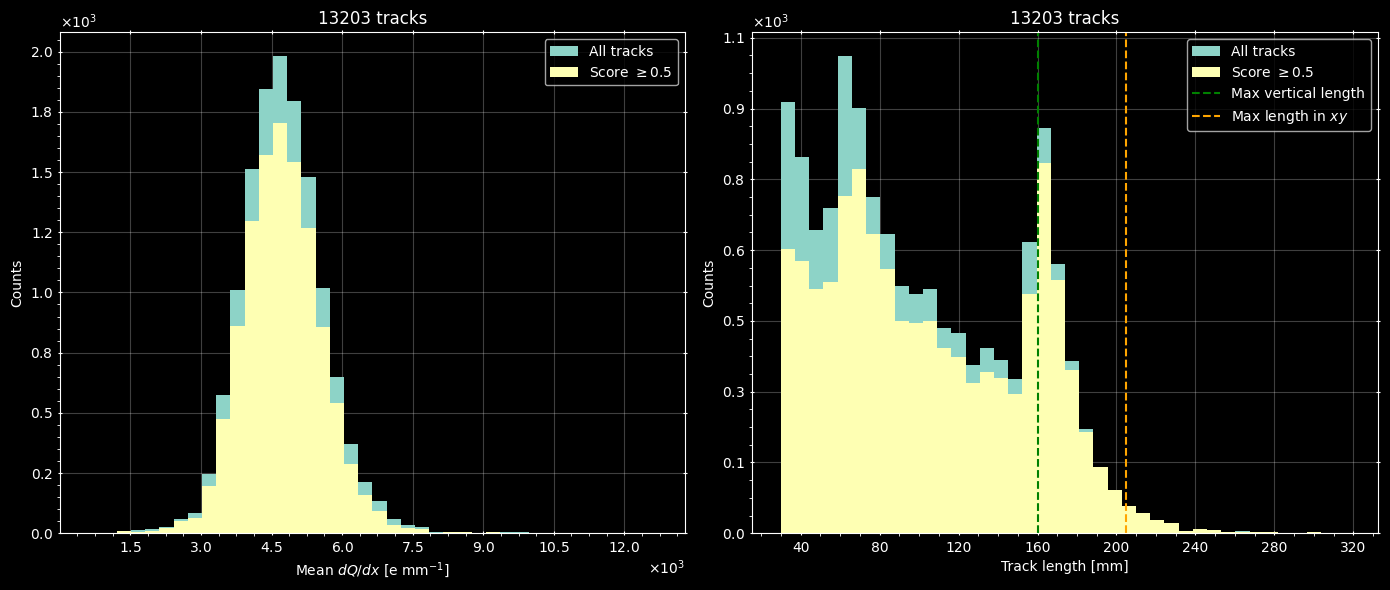

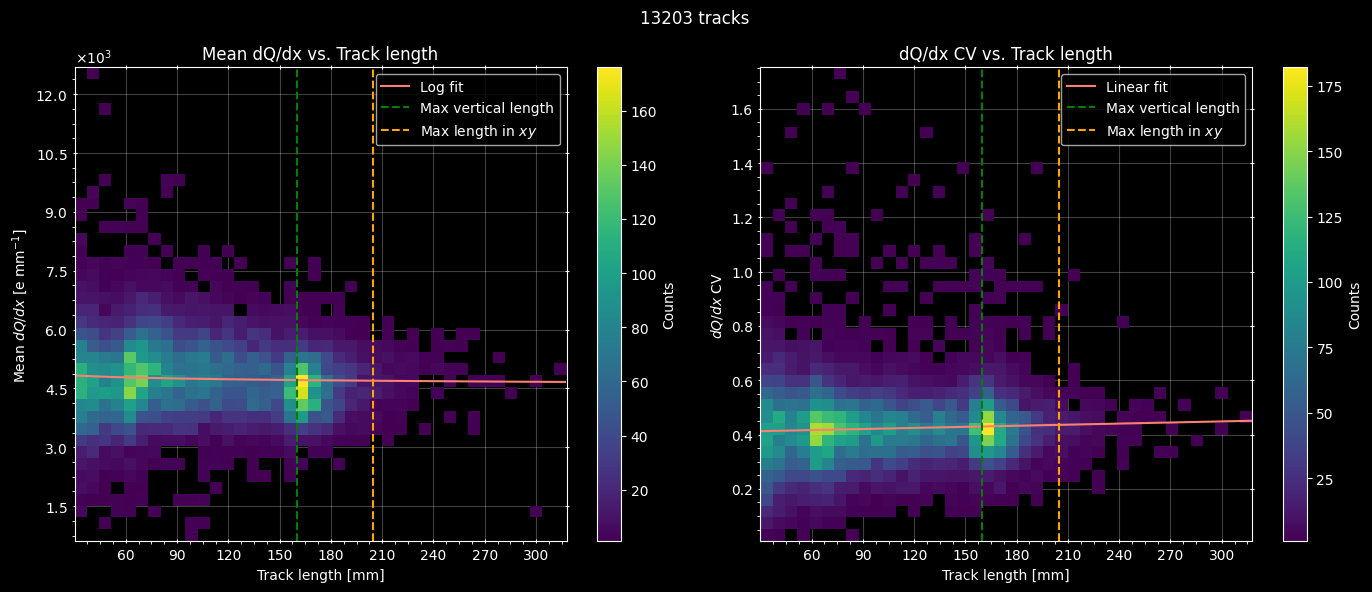

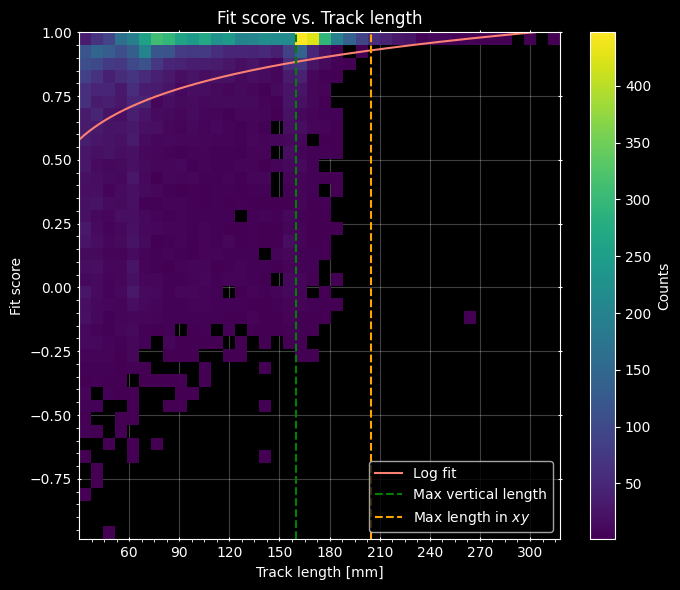

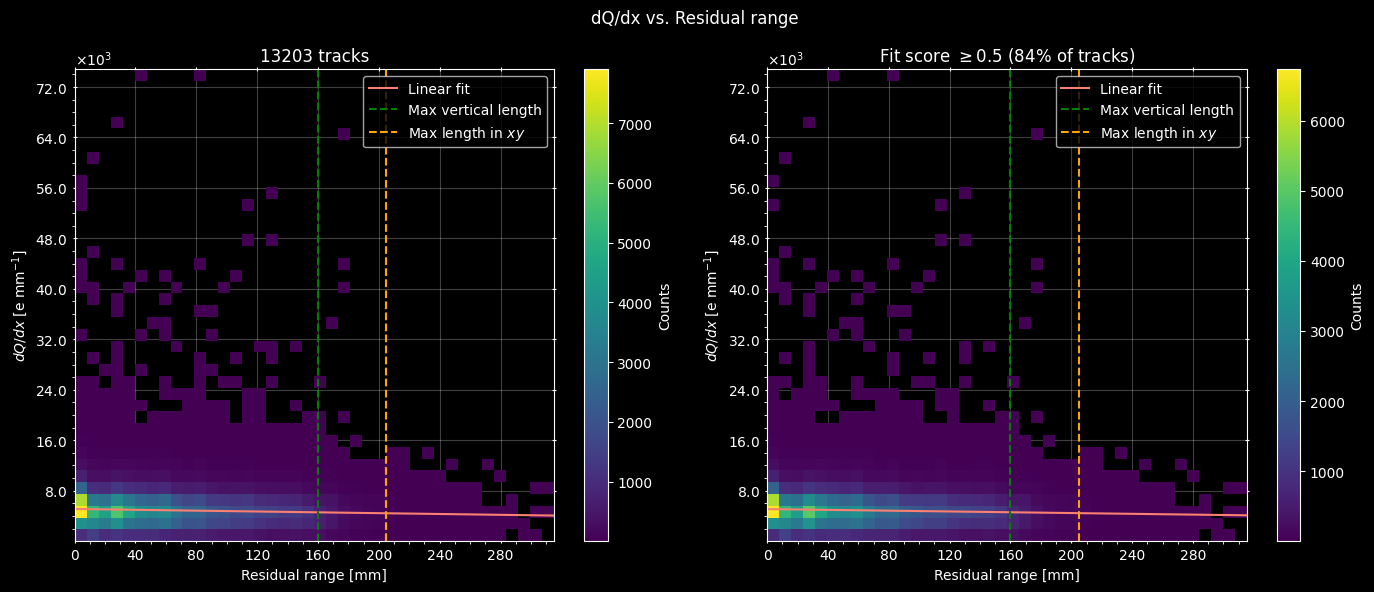

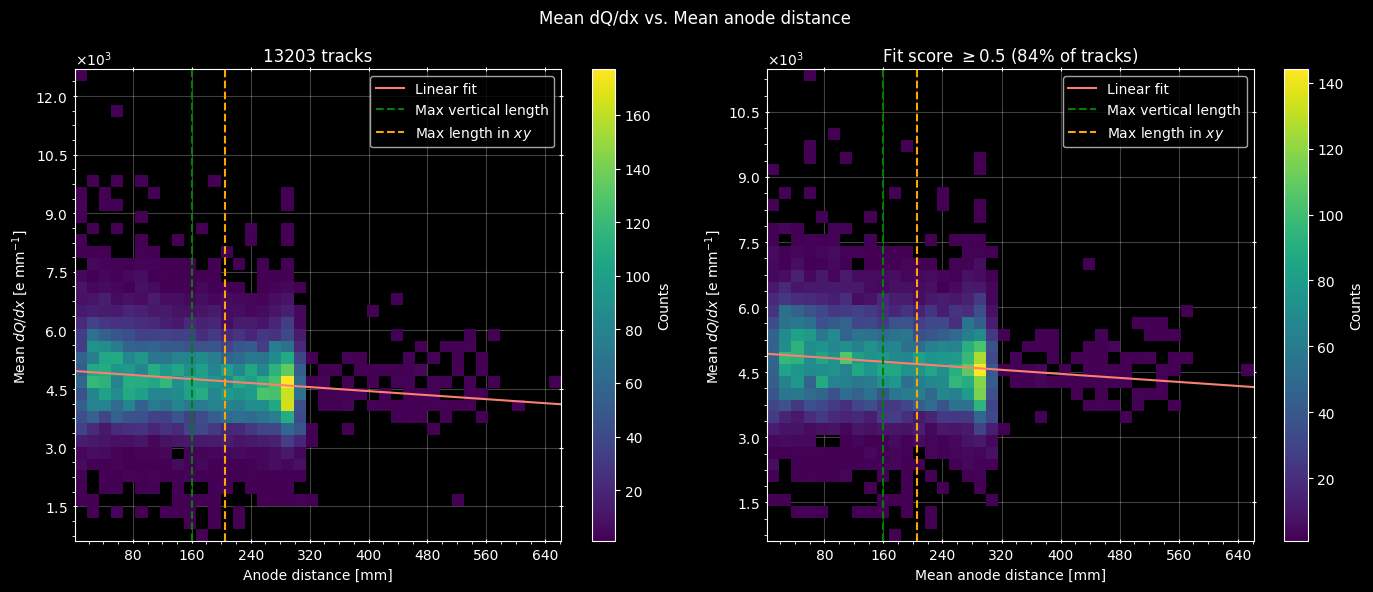

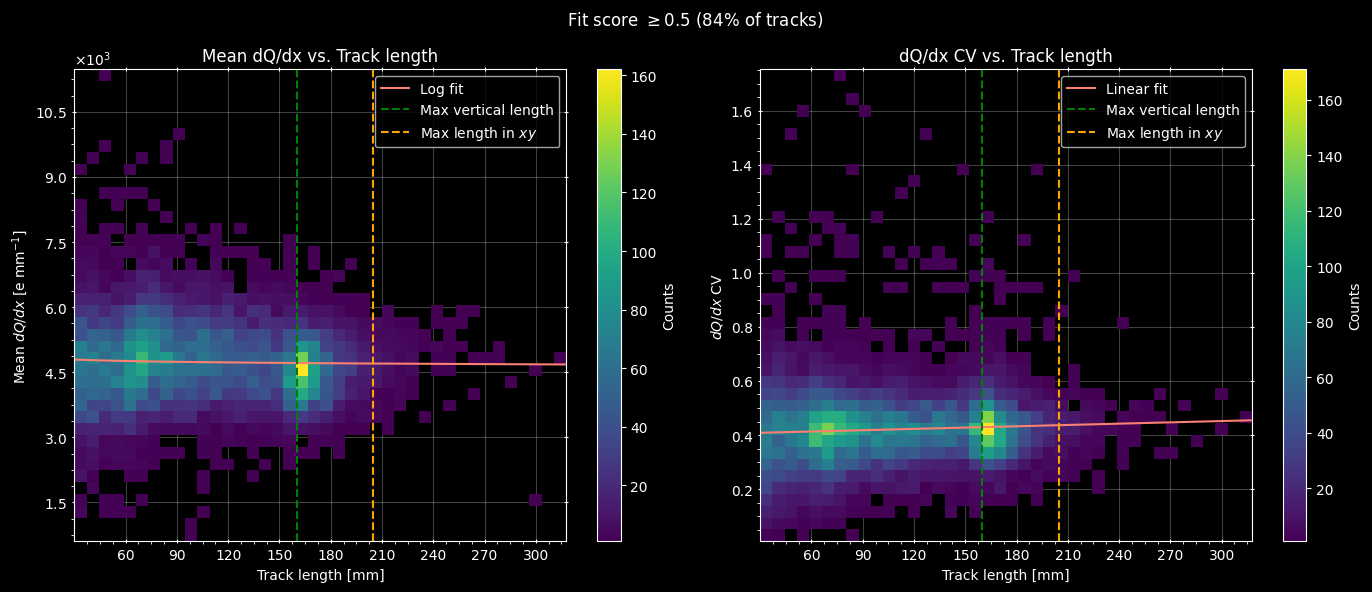

In [27]:
plot_track_stats(
    metrics,
    limit_xrange=False,
    empty_ratio_lims=(0.0, 1),
    lognorm=False,
    min_entries=2,
    min_score=0.5,
    bins=[40, 40],
    profile=False,
)
if show_figures:
    plt.show()
else:
    plt.close("all")

In [28]:
plot_track_stats(
    metrics,
    limit_xrange=False,
    empty_ratio_lims=(0.0, 1),
    lognorm=True,
    min_entries=2,
    min_score=0.5,
    bins=[40, 40],
    profile=True,
)
plt.close("all")

Tracks with dead area outside (0.0, 1) interval: 0
Tracks with less than 2 entries: 0
Remaining tracks: 13203
Tracks with score < 0.5: 2094
Remaining_tracks: 11109
Max possible track length 363.3 mm
Max possible track lengt on xy plane 204.9 mm
Max possible vertical track length 160 mm


### Individual plots

In [29]:
for event_idx in tqdm(individual_plots, leave=False):
    if event_idx in metrics:
        for track_idx, values in metrics[event_idx].items():
            if not isinstance(track_idx, str) and track_idx > 0:
                dQ_array = values["dQ"]
                dh = values["dx"]
                plot_dQ(dQ_array, event_idx, track_idx, dh, interpolate=False)

                if show_figures:
                    plt.show()
                else:
                    plt.close("all")

  0%|          | 0/49 [00:00<?, ?it/s]

In [30]:
def combine_metrics():
    combined_metrics = {}

    for file in tqdm(glob.glob("**/*.pkl"), leave=False):
        folder = file.split("/")[0]
        tqdm.write(folder)
        with open(file, "rb") as f:
            metric = pickle.load(f)
            for key, value in tqdm(metric.items()):
                combined_metrics[f"{folder}_{key}"] = value

    with open("combined_metrics.pkl", "wb") as o:
        pickle.dump(combined_metrics, o)

    print("Done")

## Light to track Geometry

In [31]:
warnings.filterwarnings("ignore", category=Warning, module="numpy")

In [32]:
plot_light_geo_stats(
    metrics,
    single_track=True,
    limit_xrange=True,
    lognorm=True,
    min_count_ratio=0.98,
    max_std_ratio=0.2,
)
if show_figures:
    plt.show()
else:
    plt.close("all")

Max possible distance to track 363.3 mm
Drift distance 300 mm
Max STD ratio 0.2 limited to 98.0 % of events: 8193 

Fit mean track length: 96.90337101140224


In [ ]:
warnings.filterwarnings("default", category=Warning)

## Total Light vs. Charge

In [ ]:
warnings.filterwarnings("ignore", category=Warning, module="numpy")

In [ ]:
light_vs_charge(metrics, clusters=1, bin_density=1, log=(True, False), p0=True)

if show_figures:
    plt.show()
else:
    plt.close("all")

In [ ]:
# Reset the warning filter (optional)
warnings.filterwarnings("default", category=Warning)

## Voxelized Light vs. Charge

In [ ]:
warnings.filterwarnings("ignore", category=Warning, module="numpy")

In [ ]:
def plot_voxel_data(metrics):
    z = []
    q = []
    l = []
    for i, metric in metrics.items():
        # if not metric["SiPM"]:
        #     continue
        for key, sipm in metric["SiPM"].items():
            if isinstance(key, tuple):
                q.append(sipm["charge_q"])
                z.append(sipm["charge_z"])
                l.append(sipm["integral"])

    z = np.array(z)
    q = np.array(q)
    l = np.array(l)

    max_light = max_std(
        l,
        ax=None,
        min_count_ratio=0.98,
        max_std_ratio=0.1,
    )

    max_charge = np.percentile(q, 99)

    mask = (l < max_light) & (l > 0) & (q < max_charge) & (q > 0) & (z < 400)

    fig1 = plt.figure(figsize=(10, 6))
    ax1 = fig1.add_subplot(111)

    hist = ax1.hist2d(
        z[mask],
        l[mask],
        bins=100,
        cmin=1,
    )
    cbar1 = plt.colorbar(hist[3])
    ax1.set(
        title="Light vs. z distance",
        xlabel=rf"z distance [{z_unit}]",
        ylabel=rf"Light {light_variable} [{light_unit}]",
    )
    cbar1.set_label(rf"Counts")

    def fit_func(x, a, b):
        return np.exp(-(x - a) / b)

    params, cov = curve_fit(fit_func, z[mask], l[mask])
    print(params)

    x = np.linspace(min(z[mask]), max(z[mask]), 1000)
    ax1.plot(x, fit_func(x, *params), c="r", ls="--", label=f"Exponential fit")
    set_common_ax_options(ax1)
    ax1.legend()

    fig2, axes2 = plt.subplots(3, 1, figsize=(10, 18))
    hist21 = axes2[0].hist2d(z[mask], q[mask], bins=50, cmin=1)
    cbar21 = plt.colorbar(hist21[3])
    axes2[0].set(
        title=rf"Charge vs. z distance",
        xlabel=rf"z distance [{z_unit}]",
        ylabel=rf"Charge [{q_unit}]",
    )
    cbar21.set_label(rf"Counts")

    hist22 = axes2[1].hist2d(q[mask], l[mask], bins=50, cmin=1)
    cbar22 = plt.colorbar(hist22[3])
    axes2[1].set(
        title=rf"Light vs. Charge",
        xlabel=rf"Charge [{q_unit}]",
        ylabel=rf"Light {light_variable} [{light_unit}]",
    )
    cbar22.set_label(rf"Counts")

    hist23 = axes2[2].hist2d(z[mask], q[mask], weights=l[mask], bins=50, cmin=1)
    cbar23 = plt.colorbar(hist23[3])
    axes2[2].set(
        title=rf"Charge vs. z distance with light weights",
        xlabel=rf"z distance [{z_unit}]",
        ylabel=rf"Charge [{q_unit}]",
    )
    cbar23.set_label(rf"Light {light_variable} [{light_unit}]")

    for ax in axes2:
        set_common_ax_options(ax)


plot_voxel_data(metrics)

In [ ]:
warnings.filterwarnings("default", category=Warning)

## Light fit vs. Charge fit

In [ ]:
plot_light_fit_stats(metrics)

# Other

In [ ]:
z = []
dq_z = []
for event, entry in metrics.items():
    # if not event==17:
    #     continue
    for track, values in entry.items():
        if isinstance(track, str) or track <= 0:
            continue

        dQ = values["dQ"]
        dx = values["dx"]
        fit = values["Fit_line"]
        if len(dQ) < 3:
            continue
        length = len(dQ) - 5
        mid_point = length // 2 + length % 2 - 1
        steps = np.arange(-mid_point - 3, mid_point + 3, 1) * dx
        for idx, step in enumerate(steps):
            if dQ[idx] == 0:
                continue
            dq_z.append(dQ[idx] / dx)
            z.append(fit.to_point(step + dx / 2)[2])

In [ ]:
plt.hist2d(z, dq_z, bins=100, cmin=1)
p = np.polyfit(z, dq_z, 1)
x = np.linspace(min(z), max(z), 100)
print(p)
plt.plot(x, np.polyval(p, x), c="r", ls="--", label=f"Linear fit")
plt.xlim(-20, detector_z + 20)
plt.ylim(0, 20000)
plt.show()

In [ ]:
from skspatial.objects import Vector

# Cos^2 of track angles
cosine = []
vectors = []
for idx, metric in metrics.items():
    for track_idx, track in metric.items():
        if type(track) is dict:
            if "RANSAC_score" in track and track["RANSAC_score"] < 0.5:
                continue
            if "Fit_norm" in track and track["Fit_norm"] < 1:
                continue
            if "Fit_line" in track:
                cosine.append(track["Fit_line"].direction.cosine_similarity([0, -1, 0]))
                vectors.append(track["Fit_line"].direction.to_array())

vectors = np.array(vectors)
cosine = np.array(cosine)

plt.hist(vectors[:, 0], bins=20)
plt.show()
plt.hist(vectors[:, 1], bins=20)
plt.show()
plt.hist(vectors[:, 2], bins=20)
plt.show()

plt.hist(sorted(cosine), bins=20)
plt.hist(np.linspace(-1, 1, len(cosine)), fill=False, bins=20)
plt.show()
plt.hist(np.array(sorted(cosine)) ** 2, bins=20)
plt.hist(np.linspace(-1, 1, len(cosine)) ** 2, fill=False, bins=20)
plt.show()